# Periodic transit search

In this notebook, we use `nuance` to search for a periodic transit. Let's generate some data first

In [1]:
# in order to run on all CPUs
import os
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7),
 CpuDevice(id=8),
 CpuDevice(id=9),
 CpuDevice(id=10),
 CpuDevice(id=11)]

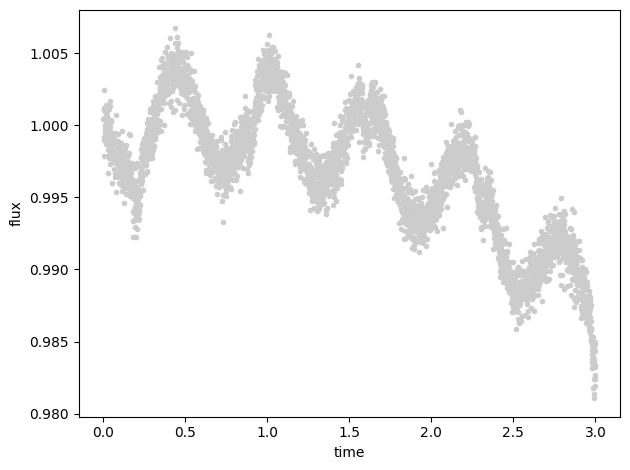

In [3]:
from nuance import Nuance, utils
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 3.0, 4000)
true = {"t0": 0.2, "D": 0.05, "P": 0.7, "depth": 2e-3}
(time, flux, error), X, gp = utils.simulated(time=t, **true)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

## The *linear search*

We start by instantiating a [Nuance](nuance.Nuance) object, and perform the *linear search* over all times (considered as potential transit epochs) and on a wide range of durations.

In [4]:
nu = Nuance(time, flux, X=X, gp=gp)

t0s = time.copy()
Ds = np.linspace(0.01, 0.2, 15)
nu.linear_search(t0s, Ds)

  0%|          | 0/334 [00:00<?, ?it/s]

```{note}
Notice how we reused the same kernel used to generate the data. In practice, a kernel need to be properly set and its hyper-parameters optimized. See the [GP optimization tutorial](gp.ipynb)
```

## The *periodic search*

We can now perform the *periodic search* and plot the SNR periodogram

In [5]:
periods = np.linspace(0.1, 5, 4000)
search = nu.periodic_search(periods)

t0, D, P = search.best

  0%|          | 0/4000 [00:00<?, ?it/s]

And we can plot the results of the search with

epoch: 0.200
duration: 0.051
period: 0.700


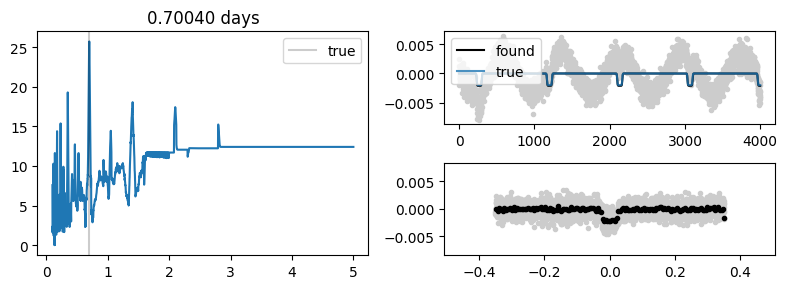

In [6]:
from nuance.utils import plot_search
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plot_search(nu, search)
plt.tight_layout()

# over plotting real values
from nuance.utils import periodic_transit

main, raw, detrended = plt.gcf().axes
main.axvline(true["P"], c="k", alpha=0.2, label="true")
main.legend()
raw.plot(
    true["depth"] * periodic_transit(time, true["t0"], true["D"], P=true["P"]),
    c="C0",
    alpha=0.8,
    label="true",
)
raw.legend()

print(
    "\n".join(
        [f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]
    )
)

```{note}
If we want to search for another planetary candidate, we can mask the current candidate and reuse the *linear search*, only the *periodic search* needs to be reran. This is demonstrated in the [Multi-planetary search notebook](multi1.ipynb)
```